In [ ]:
%spark.pyspark
# Análise exploratória com PySpark
# Autor: Felipe Melo
# Contexto: análise do dataset Olist (arquivos CSV no bucket GCS). Usamos Spark SQL + DataFrame API.


%md
# Predição de Faturamento Mensal com PySpark

## Contextualização do Problema
O objetivo deste trabalho é **prever o faturamento mensal do e-commerce** para o mês seguinte (2018-09), utilizando os dados históricos de 2017-01 até 2018-08.  
Esse tipo de previsão ajuda a empresa a se planejar financeiramente, prever sazonalidades e otimizar a logística de vendas.

## Técnica Utilizada
A técnica escolhida foi a **Regressão Linear**, pois o problema envolve prever um valor **contínuo** (receita futura) com base em variáveis históricas.  
Além disso, a regressão linear é simples, interpretável e serve como baseline para comparar com outros algoritmos mais sofisticados no futuro (ex.: Random Forest Regressor).

## Planejamento da Infraestrutura Spark
O Spark foi escolhido porque permite:
- **Escalabilidade**: processar milhões de linhas distribuídas em múltiplos nós.
- **Integração com SQL**: análise exploratória com consultas distribuídas.
- **Machine Learning em larga escala**: via biblioteca `pyspark.ml`.

Assim, todo o pipeline de dados (ETL → Análise → Modelagem → Avaliação) pode ser feito em uma infraestrutura distribuída e escalável.


%md
# Estrutura do Notebook

1. **Carregamento dos Dados**  
   - Leitura com Spark e criação de views temporárias.

2. **Análise Exploratória dos Dados (EDA)**  
   - Consultas SQL para entender pedidos, vendedores e produtos.  
   - Visualizações gráficas para compreender tendências e distribuições.

3. **Preparação dos Dados para Modelagem**  
   - Criação de variáveis agregadas mensais (features).  
   - Tratamento de valores nulos e seleção de colunas.

4. **Modelagem de Machine Learning**  
   - Divisão em treino e teste.  
   - Regressão Linear para prever faturamento do mês seguinte.

5. **Avaliação do Modelo**  
   - Métricas de desempenho (RMSE, R²).  
   - Comparação entre predições e valores reais.

6. **Melhorias e Sugestões Futuras**  
   - Outras técnicas de ML.  
   - Criação de novas features.  
   - Ajustes de hiperparâmetros.


%md
# Melhorias no Modelo de Predição

Apesar da regressão linear fornecer um baseline inicial, há várias formas de melhorar a previsão:

1. **Testar outros algoritmos**  
   - Random Forest Regressor (captura não linearidades).  
   - Gradient Boosted Trees.  

2. **Criar novas features**  
   - Quantidade média de itens por pedido.  
   - Faturamento médio por categoria de produto.  
   - Variáveis sazonais (mês do ano, trimestre).

3. **Normalização e transformação de dados**  
   - Escalonar variáveis para melhorar convergência.  

4. **Validação cruzada (Cross-Validation)**  
   - Avaliar a robustez do modelo em diferentes partições.  

Essas melhorias poderiam aumentar a precisão da previsão e tornar o modelo mais confiável para uso real em planejamento estratégico.


In [ ]:
%spark.pyspark
from pyspark.sql import functions as F
from pyspark.sql.types import *

In [ ]:
%spark.pyspark
base_path = "gs://olist-csv-bucket/"

customers = spark.read.option("header","true").option("inferSchema","true").csv(base_path + "olist_customers_dataset.csv")
orders = spark.read.option("header","true").option("inferSchema","true").csv(base_path + "olist_orders_dataset.csv")
order_items = spark.read.option("header","true").option("inferSchema","true").csv(base_path + "olist_order_items_dataset.csv")
payments = spark.read.option("header","true").option("inferSchema","true").csv(base_path + "olist_order_payments_dataset.csv")
products = spark.read.option("header","true").option("inferSchema","true").csv(base_path + "olist_products_dataset.csv")
sellers = spark.read.option("header","true").option("inferSchema","true").csv(base_path + "olist_sellers_dataset.csv")
reviews = spark.read.option("header","true").option("inferSchema","true").csv(base_path + "olist_order_reviews_dataset.csv")





In [ ]:
%spark.pyspark
customers.createOrReplaceTempView("customers")
orders.createOrReplaceTempView("orders")
order_items.createOrReplaceTempView("order_items")
payments.createOrReplaceTempView("payments")
products.createOrReplaceTempView("products")
sellers.createOrReplaceTempView("sellers")
reviews.createOrReplaceTempView("reviews")

In [ ]:
%spark.pyspark
#contagem de registros
print("Customers:", customers.count())
print("Orders:", orders.count())
print("Order Items:", order_items.count())
print("Payments:", payments.count())
print("Products:", products.count())
print("Sellers:", sellers.count())
print("Reviews:", reviews.count())


Customers: 99441
Orders: 99441
Order Items: 112650
Payments: 103886
Products: 32951
Sellers: 3095
Reviews: 104162


In [ ]:
%spark.pyspark
df_orders_status = spark.sql("""
    SELECT order_status, COUNT(*) AS total_orders
    FROM orders
    GROUP BY order_status
    ORDER BY total_orders DESC
""")
df_orders_status.show()


+------------+------------+
|order_status|total_orders|
+------------+------------+
|   delivered|       96478|
|     shipped|        1107|
|    canceled|         625|
| unavailable|         609|
|    invoiced|         314|
|  processing|         301|
|     created|           5|
|    approved|           2|
+------------+------------+



In [ ]:
%spark.pyspark
from pyspark.sql.functions import col, count

orders.join(customers, "customer_id") \
      .groupBy("customer_state") \
      .agg(count("order_id").alias("total_orders")) \
      .orderBy(col("total_orders").desc()) \
      .show(10)


+--------------+------------+
|customer_state|total_orders|
+--------------+------------+
|            SP|       41746|
|            RJ|       12852|
|            MG|       11635|
|            RS|        5466|
|            PR|        5045|
|            SC|        3637|
|            BA|        3380|
|            DF|        2140|
|            ES|        2033|
|            GO|        2020|
+--------------+------------+
only showing top 10 rows



In [ ]:
%spark.pyspark
from pyspark.sql.functions import sum

payments.groupBy("payment_type") \
        .agg(sum("payment_value").alias("total_revenue")) \
        .orderBy(col("total_revenue").desc()) \
        .show()


+------------+--------------------+
|payment_type|       total_revenue|
+------------+--------------------+
| credit_card|1.2542084189999508E7|
|      boleto|  2869361.2699999996|
|     voucher|  379436.87000000046|
|  debit_card|  217989.79000000018|
| not_defined|                 0.0|
+------------+--------------------+



In [ ]:
%spark.pyspark
df_revenue_product = spark.sql("""
    SELECT 
        oi.product_id,
        SUM(oi.price) AS total_revenue
    FROM order_items oi
    GROUP BY oi.product_id
    ORDER BY total_revenue DESC
    LIMIT 10
""")
df_revenue_product.show()


+--------------------+------------------+
|          product_id|     total_revenue|
+--------------------+------------------+
|bb50f2e236e5eea01...|           63885.0|
|6cdd53843498f9289...| 54730.20000000005|
|d6160fb7873f18409...|48899.340000000004|
|d1c427060a0f73f6b...| 47214.51000000006|
|99a4788cb24856965...|43025.560000000085|
|3dd2a17168ec895c7...| 41082.60000000005|
|25c38557cf793876c...| 38907.32000000001|
|5f504b3a1c75b73d6...|37733.899999999994|
|53b36df67ebb7c415...| 37683.42000000001|
|aca2eb7d00ea1a7b8...| 37608.90000000007|
+--------------------+------------------+



In [ ]:
%spark.pyspark
df_monthly_revenue = spark.sql("""
    SELECT 
        DATE_FORMAT(o.order_purchase_timestamp, 'yyyy-MM') AS year_month,
        SUM(oi.price) AS total_revenue
    FROM orders o
    JOIN order_items oi ON o.order_id = oi.order_id
    GROUP BY DATE_FORMAT(o.order_purchase_timestamp, 'yyyy-MM')
    ORDER BY year_month DESC
""")

df_monthly_revenue.show(20)


+----------+------------------+
|year_month|     total_revenue|
+----------+------------------+
|   2018-09|             145.0|
|   2018-08| 854686.3300000085|
|   2018-07| 895507.2200000074|
|   2018-06|  865124.310000007|
|   2018-05| 996517.6800000133|
|   2018-04| 996647.7500000133|
|   2018-03| 983213.4400000148|
|   2018-02| 844178.7100000086|
|   2018-01|  950030.360000015|
|   2017-12| 743914.1700000004|
|   2017-11|1010271.3700000155|
|   2017-10| 664219.4299999973|
|   2017-09| 624401.6899999977|
|   2017-08| 573971.6799999981|
|   2017-07| 498031.4799999967|
|   2017-06| 433038.5999999939|
|   2017-05| 506071.1399999948|
|   2017-04| 359927.2299999956|
|   2017-03|374344.29999999516|
|   2017-02| 247303.0199999985|
+----------+------------------+
only showing top 20 rows



In [ ]:
%spark.pyspark
df_orders_status = spark.sql("""
    SELECT 
        order_status, 
        COUNT(*) AS total_pedidos
    FROM orders
    GROUP BY order_status
    ORDER BY total_pedidos DESC
""")

df_orders_status.show()


+------------+-------------+
|order_status|total_pedidos|
+------------+-------------+
|   delivered|        96478|
|     shipped|         1107|
|    canceled|          625|
| unavailable|          609|
|    invoiced|          314|
|  processing|          301|
|     created|            5|
|    approved|            2|
+------------+-------------+



In [ ]:
%spark.pyspark
df_sellers_state = spark.sql("""
    SELECT 
        seller_state, 
        COUNT(*) AS total_vendedores
    FROM sellers
    GROUP BY seller_state
    ORDER BY total_vendedores DESC
""")

df_sellers_state.show()


+------------+----------------+
|seller_state|total_vendedores|
+------------+----------------+
|          SP|            1849|
|          PR|             349|
|          MG|             244|
|          SC|             190|
|          RJ|             171|
|          RS|             129|
|          GO|              40|
|          DF|              30|
|          ES|              23|
|          BA|              19|
|          CE|              13|
|          PE|               9|
|          PB|               6|
|          MS|               5|
|          RN|               5|
|          MT|               4|
|          RO|               2|
|          SE|               2|
|          AM|               1|
|          AC|               1|
+------------+----------------+
only showing top 20 rows



In [ ]:
%spark.pyspark
df_top_products = spark.sql("""
    SELECT 
        product_category_name, 
        COUNT(*) AS total_produtos
    FROM products
    GROUP BY product_category_name
    ORDER BY total_produtos DESC
    LIMIT 10
""")

df_top_products.show()


+---------------------+--------------+
|product_category_name|total_produtos|
+---------------------+--------------+
|      cama_mesa_banho|          3029|
|        esporte_lazer|          2867|
|     moveis_decoracao|          2657|
|         beleza_saude|          2444|
| utilidades_domest...|          2335|
|           automotivo|          1900|
| informatica_acess...|          1639|
|           brinquedos|          1411|
|   relogios_presentes|          1329|
|            telefonia|          1134|
+---------------------+--------------+



In [ ]:
%spark.pyspark
df_monthly_revenue = spark.sql("""
    SELECT 
        DATE_FORMAT(o.order_purchase_timestamp, 'yyyy-MM') AS year_month,
        SUM(oi.price) AS total_revenue
    FROM orders o
    JOIN order_items oi ON o.order_id = oi.order_id
    GROUP BY DATE_FORMAT(o.order_purchase_timestamp, 'yyyy-MM')
    ORDER BY year_month asc
""")

df_monthly_revenue.show(20)


+----------+------------------+
|year_month|     total_revenue|
+----------+------------------+
|   2016-09|            267.36|
|   2016-10| 49507.66000000009|
|   2016-12|              10.9|
|   2017-01|120312.87000000032|
|   2017-02| 247303.0199999985|
|   2017-03|374344.29999999516|
|   2017-04| 359927.2299999956|
|   2017-05| 506071.1399999948|
|   2017-06| 433038.5999999939|
|   2017-07| 498031.4799999967|
|   2017-08| 573971.6799999981|
|   2017-09| 624401.6899999977|
|   2017-10| 664219.4299999973|
|   2017-11|1010271.3700000155|
|   2017-12| 743914.1700000004|
|   2018-01|  950030.360000015|
|   2018-02| 844178.7100000086|
|   2018-03| 983213.4400000148|
|   2018-04| 996647.7500000133|
|   2018-05| 996517.6800000133|
+----------+------------------+
only showing top 20 rows



In [ ]:

%spark.pyspark
# Receita por ano-mês
df_monthly = spark.sql("""
    SELECT 
        DATE_FORMAT(o.order_purchase_timestamp, 'yyyy-MM') AS year_month,
        SUM(oi.price) AS total_revenue
    FROM orders o
    JOIN order_items oi ON o.order_id = oi.order_id
    GROUP BY DATE_FORMAT(o.order_purchase_timestamp, 'yyyy-MM')
    ORDER BY year_month
""")

df_filtered = df_monthly.filter(
    (df_monthly.year_month >= "2017-01") & (df_monthly.year_month <= "2018-08")
)

df_filtered.show(10)


+----------+------------------+
|year_month|     total_revenue|
+----------+------------------+
|   2017-01|120312.87000000032|
|   2017-02| 247303.0199999985|
|   2017-03|374344.29999999516|
|   2017-04| 359927.2299999956|
|   2017-05| 506071.1399999948|
|   2017-06| 433038.5999999939|
|   2017-07| 498031.4799999967|
|   2017-08| 573971.6799999981|
|   2017-09| 624401.6899999977|
|   2017-10| 664219.4299999973|
+----------+------------------+
only showing top 10 rows




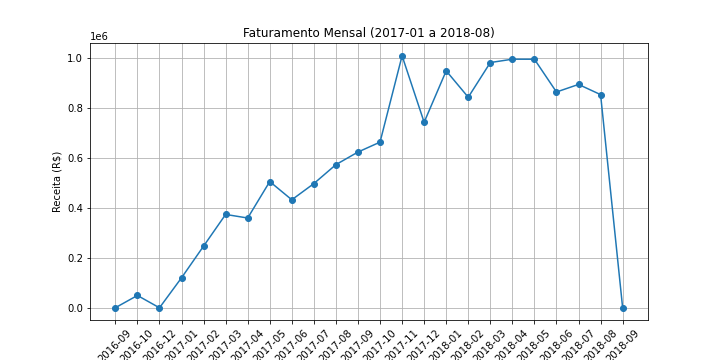

In [ ]:
%spark.pyspark
import matplotlib.pyplot as plt

# Converter para Pandas para plotar
pdf_revenue = df_monthly_revenue.toPandas()

plt.figure(figsize=(10,5))
plt.plot(pdf_revenue["year_month"], pdf_revenue["total_revenue"], marker="o")
plt.xticks(rotation=45)
plt.title("Faturamento Mensal (2017-01 a 2018-08)")
plt.xlabel("Ano-Mês")
plt.ylabel("Receita (R$)")
plt.grid(True)
plt.show()




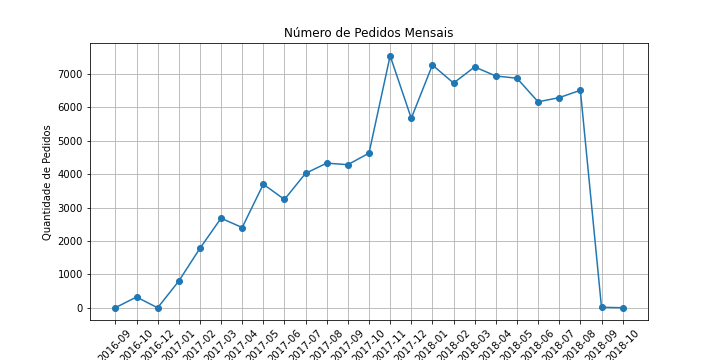

In [ ]:
%spark.pyspark
from pyspark.sql.functions import col, date_format, count


df_orders_monthly = orders.withColumn("year_month", date_format(col("order_purchase_timestamp"), "yyyy-MM"))


df_monthly_orders = df_orders_monthly.groupBy("year_month") \
                                     .agg(count("order_id").alias("num_orders")) \
                                     .orderBy("year_month")


pdf_orders = df_monthly_orders.toPandas()




plt.figure(figsize=(10,5))
plt.plot(pdf_orders["year_month"], pdf_orders["num_orders"], marker="o")
plt.xticks(rotation=45)
plt.title("Número de Pedidos Mensais")
plt.xlabel("Ano-Mês")
plt.ylabel("Quantidade de Pedidos")
plt.grid(True)
plt.show()


In [ ]:
%spark.pyspark
from pyspark.sql.window import Window
from pyspark.sql.functions import lead


window_spec = Window.orderBy("year_month")
df_ml = df_filtered.withColumn(
    "next_month_revenue", lead("total_revenue").over(window_spec)
)


df_ml = df_ml.na.drop(subset=["next_month_revenue"])

df_ml.show(5)


+----------+------------------+------------------+
|year_month|     total_revenue|next_month_revenue|
+----------+------------------+------------------+
|   2017-01|120312.87000000032| 247303.0199999985|
|   2017-02| 247303.0199999985|374344.29999999516|
|   2017-03|374344.29999999516| 359927.2299999956|
|   2017-04| 359927.2299999956| 506071.1399999948|
|   2017-05| 506071.1399999948| 433038.5999999939|
+----------+------------------+------------------+
only showing top 5 rows



In [ ]:
%spark.pyspark
from pyspark.sql.functions import split, col

df_ml = df_ml.withColumn("year", split(col("year_month"), "-")[0].cast("int"))
df_ml = df_ml.withColumn("month", split(col("year_month"), "-")[1].cast("int"))

df_ml.select("year_month", "year", "month", "total_revenue", "next_month_revenue").show(5)


+----------+----+-----+------------------+------------------+
|year_month|year|month|     total_revenue|next_month_revenue|
+----------+----+-----+------------------+------------------+
|   2017-01|2017|    1|120312.87000000032| 247303.0199999985|
|   2017-02|2017|    2| 247303.0199999985|374344.29999999516|
|   2017-03|2017|    3|374344.29999999516| 359927.2299999956|
|   2017-04|2017|    4| 359927.2299999956| 506071.1399999948|
|   2017-05|2017|    5| 506071.1399999948| 433038.5999999939|
+----------+----+-----+------------------+------------------+
only showing top 5 rows



In [ ]:
%spark.pyspark
from pyspark.ml.feature import VectorAssembler

feature_cols = ["year", "month", "total_revenue"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df_final = assembler.transform(df_ml).select("features", "next_month_revenue")

df_final.show(5, truncate=False)


+-------------------------------+------------------+
|features                       |next_month_revenue|
+-------------------------------+------------------+
|[2017.0,1.0,120312.87000000032]|247303.0199999985 |
|[2017.0,2.0,247303.0199999985] |374344.29999999516|
|[2017.0,3.0,374344.29999999516]|359927.2299999956 |
|[2017.0,4.0,359927.2299999956] |506071.1399999948 |
|[2017.0,5.0,506071.1399999948] |433038.5999999939 |
+-------------------------------+------------------+
only showing top 5 rows



In [ ]:
%spark.pyspark
train_df, test_df = df_final.randomSplit([0.7, 0.3], seed=42)

print("Treino:", train_df.count())
print("Teste:", test_df.count())


Treino: 12
Teste: 7


In [ ]:
%spark.pyspark
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="next_month_revenue")
lr_model = lr.fit(train_df)

print("Coeficientes:", lr_model.coefficients)
print("Intercepto:", lr_model.intercept)


Coeficientes: [266550.7710397282,33525.63246368134,0.22758386020112162]
Intercepto: -537404752.1285872


In [ ]:
%spark.pyspark
from pyspark.ml.evaluation import RegressionEvaluator

# Previsões
train_pred = lr_model.transform(train_df)
test_pred = lr_model.transform(test_df)

# Métricas
evaluator = RegressionEvaluator(labelCol="next_month_revenue", predictionCol="prediction")

rmse_train = evaluator.evaluate(train_pred, {evaluator.metricName: "rmse"})
rmse_test = evaluator.evaluate(test_pred, {evaluator.metricName: "rmse"})

r2_train = evaluator.evaluate(train_pred, {evaluator.metricName: "r2"})
r2_test = evaluator.evaluate(test_pred, {evaluator.metricName: "r2"})

print(f"Treino -> RMSE: {rmse_train:.2f}, R²: {r2_train:.2f}")
print(f"Teste  -> RMSE: {rmse_test:.2f}, R²: {r2_test:.2f}")


Treino -> RMSE: 70248.52, R²: 0.90
Teste  -> RMSE: 166650.10, R²: 0.54


In [ ]:
%spark.pyspark
from pyspark.sql.functions import lag


window_spec = Window.orderBy("year_month")
df_ml = df_ml.withColumn("prev_revenue", lag("total_revenue").over(window_spec))


df_ml = df_ml.withColumn(
    "pct_change", 
    ((col("total_revenue") - col("prev_revenue")) / col("prev_revenue")) * 100
)


df_ml = df_ml.na.fill({"prev_revenue": 0, "pct_change": 0})


feature_cols = ["year", "month", "total_revenue", "pct_change"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df_final2 = assembler.transform(df_ml).select("features", "next_month_revenue")


train_df2, test_df2 = df_final2.randomSplit([0.8, 0.2], seed=42)


lr2 = LinearRegression(featuresCol="features", labelCol="next_month_revenue")
lr_model2 = lr2.fit(train_df2)


train_pred2 = lr_model2.transform(train_df2)
test_pred2 = lr_model2.transform(test_df2)

rmse_test2 = evaluator.evaluate(test_pred2, {evaluator.metricName: "rmse"})
r2_test2 = evaluator.evaluate(test_pred2, {evaluator.metricName: "r2"})

print(f"Novo modelo -> RMSE: {rmse_test2:.2f}, R²: {r2_test2:.2f}")


Novo modelo -> RMSE: 91864.94, R²: 0.83


In [ ]:
%sh
